In [145]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.deprecated.doc2vec import LabeledSentence
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS
from string import digits

import pandas as pd
import numpy as np
import string
import re
import random 
import os
import csv

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.density import information_density

from scipy.stats import entropy
from matplotlib import pyplot as plt
%matplotlib inline

# Load Data and Clean

In [139]:
dat = pd.read_csv("all_text.csv")

In [3]:
# preprocessing (remove punctuation, numbers, lowercase)
punctuation_dictionary = {s:None for s in list(string.punctuation)}

punctuation_translator = str.maketrans(punctuation_dictionary)

def text_cleaner(text, punctuation_translator):
    text = text.replace('c("', '')
    text = str(text).translate(punctuation_translator)
    text = text.lower()
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    return(text)

dat["clean_text"] = dat["text"].apply(lambda x: text_cleaner(x, punctuation_translator))

In [8]:
# find phrases
phrases1 = Phrases(map(lambda x: x.split(), dat["clean_text"].tolist())) #bigram
phrases2 = Phrases(phrases1[map(lambda x: x.split(), dat["clean_text"].tolist())]) #trigram
dat["phrased_text"] = dat["clean_text"].apply(lambda x: " ".join(phrases2[phrases1[x.split()]]))

In [91]:
#dat

,id,text,clean_text,phrased_text
0,7VS1-X791-2R2Y-70SK-00000-00.txt,"c(""May 23--Record demand for area food pantry ...",may record demand for area food pantry program...,may record demand for area food_pantry program...
1,4VGG-NH20-TX12-N12V-00000-00.txt,"c(""Jan. 28--STOCKTON -- All but six of the 189...",jan stockton all but six of the units in the...,jan_stockton all but six of the units in the v...
2,7VTR-NPY0-Y9J0-Y26V-00000-00.txt,"c(""May 31--It's a simple question: What are yo...",may its a simple question what are you being c...,may its a simple_question what are you being c...
3,4VG1-37N0-TX12-N0MF-00000-00.txt,"c(""Jan. 25--This is the best time for buying p...",jan this is the best time for buying propertie...,jan this is the best time for buying propertie...
4,7WDR-PFY0-Y9J0-Y03G-00000-00.txt,"c(""Aug. 17--GLENS FALLS -- The Glens Falls Far...",aug glens falls the glens falls farmers marke...,aug glens_falls the glens_falls farmers_market...
...,...,...,...,...
214539,5P1D-JB81-DYY9-J17B-00000-00.txt,"""Change"" has been President-elect Barack Obama...",change has been presidentelect barack obamas m...,change has_been presidentelect_barack_obamas m...
214540,4V23-HR00-TXJ7-F169-00000-00.txt,As banks race to cover all of their payments b...,as banks race to cover all of their payments b...,as banks race to cover all of their payments b...
214541,4TKS-1W10-TX2Y-F076-00000-00.txt,Media stocks might be depressed amid the curre...,media stocks might be depressed amid the curre...,media stocks might be depressed amid the curre...
214542,7WKK-W2D0-Y9S8-W524-00000-00.txt,Party leaders from both sides have condemned h...,party leaders from both sides have condemned h...,party_leaders from both_sides have condemned h...


# doc2vec

In [93]:
docs = list(zip(dat["phrased_text"].tolist(), dat["id"].tolist()))


## Define an iterator to feed documents and tags to Doc2Vec
class Sentences(object):
    def __init__(self, docs):
        self.docs = docs
    def __iter__(self):
        for doc in self.docs:
            yield TaggedDocument(words=str(doc[0]).split(), tags=[doc[1]])

## Train and save models
model = Doc2Vec(Sentences(docs), vector_size=100, window=10, min_count=100, negative=10, epochs=10, dm=0, dbow_words=1)

In [94]:
print(len(model.docvecs))
model.save("doc2vec_wordvecs.model")
print(len(docs))
print(len(dat))



214544
214544
214544


In [95]:
model.wv.most_similar('recession') #check the model

[('deep_recession', 0.8328547477722168),
 ('economic_slump', 0.823676347732544),
 ('severe_recession', 0.8173205852508545),
 ('recessionbut', 0.7941799163818359),
 ('current_downturn', 0.7936395406723022),
 ('recessionand', 0.7841596007347107),
 ('recessionary', 0.7790869474411011),
 ('prolonged_recession', 0.7782836556434631),
 ('downturn', 0.7760612964630127),
 ('recessionit', 0.7659202814102173)]

In [41]:
# load model
model = Word2Vec.load("doc2vec_wordvecs.model") 

# Random Forest

In [140]:
## load labelled data
clas_dat1 = pd.read_csv("random_sample_CRK_YL-6-7-21.csv")
# keep relavant rows and columns
clas_dat1 = clas_dat1[['id', 'text', 'final_code']]
clas_dat2 = pd.read_csv("random_sample3_CRK.csv")
clas_dat2 = clas_dat2[['id', 'text',"include"]]
clas_dat2.columns = clas_dat1.columns
clas_dat = pd.concat([clas_dat1,clas_dat2])
# ## generate test and training set 
# clas_dat['test'] = np.random.choice([0, 1], size = len(clas_dat['id']), p = [0.8,0.2])
# merge with the total dataframe
dat = dat.merge(clas_dat[["id", "final_code"]], how = "left", on = "id")
X = np.asarray([model.docvecs[i] for i in dat[dat['id'].isin(clas_dat['id'])].index.tolist()])
y = clas_dat['final_code']

In [142]:
y.unique()

array([1, 0])

In [126]:
clas_dat

id  \
0    7WP8-9XG1-2R2Y-71SP-00000-00.txt   
1    7XCN-V6H1-2R2Y-72P9-00000-00.txt   
2    7X27-9C40-Y8T5-Y4FR-00000-00.txt   
3    4SKJ-MNP0-TWX3-K0WW-00000-00.txt   
4    7VCC-C621-2R2Y-71V4-00000-00.txt   
..                                ...   
295  7XD7-8KM0-Y9J0-Y12X-00000-00.txt   
296  4R1C-4MC0-TX4K-909J-00000-00.txt   
297  4MYD-1N40-TW8F-G3D0-00000-00.txt   
298  4TH9-7NB0-TX2G-S1PM-00000-00.txt   
299  7W3V-JV60-Y9J0-Y46R-00000-00.txt   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [143]:
# split into training and testing 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# tuning for RFC
parameters = {'n_estimators':[500, 1000, 5000], 'max_depth':[3, 5, 10], "max_features": ["sqrt", 0.2, 0.5]}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters)
clf.fit(X_train, y_train)
print(clf.best_params_) 

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 5000}


In [138]:
y_test.unique()

array([0, 1, 9])

In [144]:
# test RFC
rfc = RandomForestClassifier(n_estimators=5000, max_depth = 3, max_features ="sqrt")
## Fit the model to the training set
rfc.fit(X_train, y_train)
#PR AUC
preds = rfc.predict_proba(X_test)
lr_precision, lr_recall, _= precision_recall_curve(y_test.tolist(),  preds[:,1].tolist())
lr_auc = auc(lr_recall, lr_precision)
print(lr_auc)
confusion = confusion_matrix(y_test, rfc.predict(X_test))
print(confusion)
print(metrics.accuracy_score(y_test, rfc.predict(X_test)))

0.4870734609695811
[[43 25]
 [33 19]]
0.5166666666666667


In [146]:
# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
    print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))

[[49  9]
 [41 21]]
Precision: 0.700000
Recall: 0.338710
[[40 23]
 [36 21]]
Precision: 0.477273
Recall: 0.368421
[[43 16]
 [44 17]]
Precision: 0.515152
Recall: 0.278689
[[45 22]
 [32 21]]
Precision: 0.488372
Recall: 0.396226
[[48  5]
 [51 16]]
Precision: 0.761905
Recall: 0.238806
[[50 19]
 [29 22]]
Precision: 0.536585
Recall: 0.431373
[[48 10]
 [46 16]]
Precision: 0.615385
Recall: 0.258065
[[49 14]
 [37 20]]
Precision: 0.588235
Recall: 0.350877
[[37 28]
 [30 25]]
Precision: 0.471698
Recall: 0.454545
[[48 10]
 [48 14]]
Precision: 0.583333
Recall: 0.225806
Mean Accuracy: 0.5416666666666666
Average precision: 0.5737937819249062
Average recall: 0.3341517804174145


# bag of words + tfidf

In [147]:
# clean the labeled text the same way
clas_dat["clean_text"] = clas_dat["text"].apply(lambda x: text_cleaner(x, punctuation_translator))
phrases1 = Phrases(map(lambda x: x.split(), clas_dat["clean_text"].tolist())) #bigram
phrases2 = Phrases(phrases1[map(lambda x: x.split(), clas_dat["clean_text"].tolist())]) #trigram
clas_dat["phrased_text"] = clas_dat["clean_text"].apply(lambda x: " ".join(phrases2[phrases1[x.split()]]))

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=500, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(clas_dat["phrased_text"]).toarray()

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

y = np.array(clas_dat['final_code'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
classifier = RandomForestClassifier(n_estimators=1000,  max_depth = 3, max_features =0.5,random_state=0)
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

print("Accuracy: " + str(accuracy_score(y_test, y_pred)))



Accuracy: 0.6416666666666667


In [148]:
# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train) 
    y_pred = classifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
    print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))

[[51 10]
 [27 32]]
Precision: 0.761905
Recall: 0.542373
[[49 16]
 [20 35]]
Precision: 0.686275
Recall: 0.636364
[[41 25]
 [16 38]]
Precision: 0.603175
Recall: 0.703704
[[42 17]
 [22 39]]
Precision: 0.696429
Recall: 0.639344
[[58  9]
 [22 31]]
Precision: 0.775000
Recall: 0.584906
[[50 14]
 [24 32]]
Precision: 0.695652
Recall: 0.571429
[[54  9]
 [20 37]]
Precision: 0.804348
Recall: 0.649123
[[53 17]
 [17 33]]
Precision: 0.660000
Recall: 0.660000
[[45  6]
 [31 38]]
Precision: 0.863636
Recall: 0.550725
[[48 13]
 [26 33]]
Precision: 0.717391
Recall: 0.559322
Mean Accuracy: 0.6991666666666666
Average precision: 0.7263810114296048
Average recall: 0.6097288194121292


# Logistic Regression Classifier (BOW+ Tf-Idf)

In [150]:
from sklearn.linear_model import LogisticRegression

# for robust results, bootstrap the process
accuracy_scores= []
precision_scores = []
recall_scores = []

for i in range(0,10):
    ## load the test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    ## Predict out-of-sample on the test set and compute accuracy
    accuracy_scores= accuracy_scores+ [accuracy_score(y_test, y_pred)]
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    precision_scores= precision_scores+ [precision]
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    recall_scores= recall_scores+ [recall]
    print('Recall: %f' % recall)

print("Mean Accuracy: " + str(np.mean(accuracy_scores)))
print("Average precision: " + str(np.mean(precision_scores)))
print("Average recall: " + str(np.mean(recall_scores)))

[[48 12]
 [27 33]]
Precision: 0.733333
Recall: 0.550000
[[53  8]
 [24 35]]
Precision: 0.813953
Recall: 0.593220
[[46 16]
 [22 36]]
Precision: 0.692308
Recall: 0.620690
[[52  7]
 [31 30]]
Precision: 0.810811
Recall: 0.491803
[[43 10]
 [29 38]]
Precision: 0.791667
Recall: 0.567164
[[49 12]
 [27 32]]
Precision: 0.727273
Recall: 0.542373
[[49 13]
 [24 34]]
Precision: 0.723404
Recall: 0.586207
[[49  8]
 [34 29]]
Precision: 0.783784
Recall: 0.460317
[[47 20]
 [21 32]]
Precision: 0.615385
Recall: 0.603774
[[46 18]
 [29 27]]
Precision: 0.600000
Recall: 0.482143
Mean Accuracy: 0.6733333333333333
Average precision: 0.729191737325087
Average recall: 0.54976911322221


# Active Learning

In [32]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.density import information_density

# split into training and testing (can't bootstrap here)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

learner = ActiveLearner(
    estimator= RandomForestClassifier(n_estimators=1000, random_state=0),
    query_strategy=uncertainty_sampling,
    X_training=X_train, y_training=y_train
)

# generate the unlabelled pool
unlabelled = dat[((~dat['id'].isin(clas_dat.id)).tolist())]
X_pool = vectorizer.fit_transform(unlabelled["phrased_text"]).toarray()

tfidfconverter = TfidfTransformer()
X_pool = tfidfconverter.fit_transform(X_pool).toarray()


[115166 115198  41270  41234 114807  41141   1099 114682 115213  15511]


In [33]:
# start the interactive active learning labeling session
accuracy_scores_al = [learner.score(X_test, y_test)]
X_pool_text = unlabelled['clean_text']

for i in range(10):
    query_idx, query_inst = learner.query(X_pool)
    print(X_pool_text[query_idx])
    y_new = np.array([int(input())], dtype=int)
    learner.teach(query_inst, y_new)
    X_pool = np.delete(X_pool, query_idx, axis=0)
    accuracy_scores_al.append(learner.score(X_test, y_test))

Is it about recession
37    gold prices rushed past the perounce mark in early september to hit their highest level since march  thats surprising to peter ricchiuti assistant dean of the ab freeman school of business at tulane universityi find it kind of odd that gold prices have been so strong and the economy is going in the opposite direction ricchiuti saidricchiuti believes the recession ended this summer and he said a rebounding economy traditionally forecasts a drop in gold prices gold is considered one of the safest investments so high prices typically indicate low investor confidence ricchiuti called it the antiinvestment david beahm vice president of economic research at new orleansbased precious metals retailer blanchard and co said  per ounce is a psychological barrier it triggers people to increase their buying habits beahm said any time the price of gold gets to one of these psychological barriers we have an influx of new clients and existing clients looking to buy more bea

1
Is it about recession
0    may record demand for area food pantry programs is outpacing donations officials with the brazos valley food bank said this weekrequests for assistance from the food pantries have increased  percent in recent months while donations of food and money have steadily decreased said theresa mangapora the brazos valley food banks executive directorthe food bank operates on a  annual budget and provided about  people with a record  million pounds of food last year mangapora said adding that most of the people the agency helps use its services repeatedly throughout the yeararea food pantries rely largely  and sometimes exclusively  on the food bank to stock their shelves and with more people looking for help officials said the food bank is struggling to keep upwe want to fill the shelves of the pantries and the pantries want to fill the shelves of the families mangapora saidmany people are under the impression that brazos county isnt suffering the effects of the na

1
Is it about recession
855    nov mitchells an upscale clothier based in westport wants to acquire wilkes bashford co a san franciscobased highend department store chain that recently filed for chapter  bankruptcy protectionwe think theres tremendous synergies and the business has a tremendous reputation and iconic brand on the west coast said andrew mitchellnamdar mitchells vice president of marketing and coownerwilkes bashford has a squarefoot sixstory flagship store on san franciscos sutter street and another squarefoot store in palo alto califwilkes bashford which was founded in  and carries pricy labels such as zegna and kiton in the past two months shuttered locations in mill valley and carmel calif after weak sales brought on by the recession since february it has reduced its work force from  employees to mitchells would pay  million under a proposed agreement with the bankruptcy court pending a competitive bid process to allow for other offerswilkes bashford is seeking approva

1
Is it about recession
509    sep even in a recession some businesses growin san diego and riverside counties farmers markets are blossoming as a growth enterprise propelled by expanding demand for fresh nutritious foods grown locallyfive years ago san diego county hosted  farmers markets now  operate and the number of stalls at most farmers markets also is growing at the oceanside certified farmers market amp faire the number of vendors has risen to  today triple the number when the market started  years agosoon the market will expand adding as many as  vendorspeople want to buy local said suzanne bendixen manager of the oceanside market and of markets in poway and la mesain riverside county just seven farmers markets served the county  which is almost the size of new jersey  a decade ago now that number has doubled and farmers markets in hemet and corona soon will open said don bray deputy riverside county agricultural commissioner farmers market operators all say they keep waiting 

1


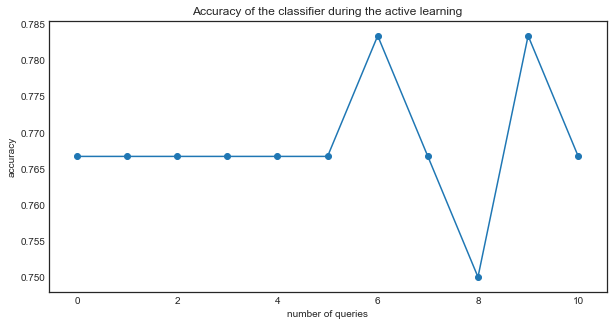

In [35]:
# visualize the results 
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(10+1), accuracy_scores_al)
    plt.scatter(range(10+1), accuracy_scores_al)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

# generate new sample

In [69]:
# labelled data
clas_dat1 = pd.read_csv("random_sample_CRK_YL-6-7-21.csv")
clas_dat2 = pd.read_csv("random_sample2.csv")

labelled_id = clas_dat1['id'].append(clas_dat2['id'])

In [74]:
pool = dat[~dat['id'].isin(labelled_id)]
sample3 = pool.sample(n = 300)

In [76]:
sample3.to_csv("random_sample3.csv")

In [77]:
len(dat)

214544

In [78]:
len(pool)

213944